In [1]:
import os
import sys
sys.path.append(f'{os.getcwd()}/../../')
sys.path.append(f'{os.getcwd()}/analytic')

import numpy             as np
import matplotlib.pyplot as plt
import magritte.setup    as setup
import magritte.core     as magritte

In [2]:
magritte.n_threads_avail()

8

In [3]:
magritte.set_n_threads_avail(8)
magritte.    n_threads_avail()

8

In [4]:
model = magritte.Model()

In [5]:
model.set()

0

In [6]:
magritte.set_n_threads_avail(8)
magritte.    n_threads_avail()

8

In [7]:
%timeit model.add()

11.3 ms ± 444 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
magritte.set_n_threads_avail(1)
magritte.    n_threads_avail()

1

In [9]:
%timeit model.add()

42.7 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
np.array(model.add())

array([], dtype=float128)

TypeError: Unable to convert function return value to a Python type! The signature was
	(self: magritte.core.Model) -> paracabs::multi_threading::ThreadPrivate<paracabs::datatypes::Vector<long double> >

In [2]:
dimension = 1
npoints   = 100
nrays     = 200
nspecs    = 5
nlspecs   = 1
nquads    = 21

r_in   = 1.0E13   # [m]
r_out  = 7.8E16   # [m]
rho_in = 2.0E13   # [m^-3]
X_mol  = 1.0E-8   # [.]
temp   = 20.0     # [K]
turb   = 150.00   # [.]


def rho (r):
    return rho_in * np.power(r_in/r, 2.0)

def abn (r):
    return X_mol * rho(r)


rs = np.logspace (np.log10(r_in), np.log10(r_out), npoints, endpoint=True)
# rs = np.linspace (r_in, r_out, npoints, endpoint=True)

modelFile = 'vanZadelhoff_1a_1D.hdf5'
lamdaFile = '../data/test.txt'


model = magritte.Model ()
model.parameters.set_spherical_symmetry(True)
model.parameters.set_pop_prec          (1.0e-6)
model.parameters.set_model_name        (modelFile)
model.parameters.set_dimension         (dimension)
model.parameters.set_npoints           (npoints)
model.parameters.set_nrays             (nrays)
model.parameters.set_nspecs            (nspecs)
model.parameters.set_nlspecs           (nlspecs)
model.parameters.set_nquads            (nquads)

model.geometry.points.position.set([[r, 0, 0] for r in rs])
model.geometry.points.velocity.set(np.zeros((npoints, 3)))

model.chemistry.species.abundance = [[     0.0, abn(r), rho(r),  0.0,      1.0] for r in rs]
model.chemistry.species.symbol    =  ['dummy0', 'test',   'H2', 'e-', 'dummy1']

model.thermodynamics.temperature.gas  .set( temp                 * np.ones(npoints))
model.thermodynamics.turbulence.vturb2.set((turb/magritte.CC)**2 * np.ones(npoints))

model = setup.set_Delaunay_neighbor_lists (model)
model = setup.set_Delaunay_boundary       (model)
model = setup.set_boundary_condition_CMB  (model)
model = setup.set_rays_spherical_symmetry (model)
model = setup.set_linedata_from_LAMDA_file(model, lamdaFile)
model = setup.set_quadrature              (model)

print(model.geometry.boundary.get_boundary_condition(0))

model.write()
model.read ()

model.compute_spectral_discretisation ()
model.compute_inverse_line_widths     ()
model.compute_LTE_level_populations   ()
model.compute_level_populations       (False, 50)

BoundaryCondition.CMB


34

In [3]:
# model.compute_radiation_field()
# model.compute_Jeff           ()

In [4]:
model.compute_radiation_field_2nd_order_Feautrier()
model.compute_Jeff           ()

0

In [5]:
Jeff = np.array(model.lines.lineProducingSpecies[0].Jeff).ravel()

In [6]:
import h5py as h5

with h5.File(modelFile) as f:
    a = np.array(f['geometry/boundary/boundary_condition'])
    print(a.dtype)

|S3


In [7]:
model.geometry.boundary.get_boundary_condition(0)

BoundaryCondition.Thermal

In [8]:
np.array(model.geometry.boundary.boundary_temperature)

array([2.72548, 2.72548], dtype=float128)

In [9]:
rs

array([1.00000000e+13, 9.39774487e+13, 8.83176087e+14, 8.29986354e+15,
       7.80000000e+16])

In [10]:
Jeff

array([8.82322309e-17, 1.08073809e-16, 9.16949022e-17, 2.15675253e-17,
       7.06327138e-18])

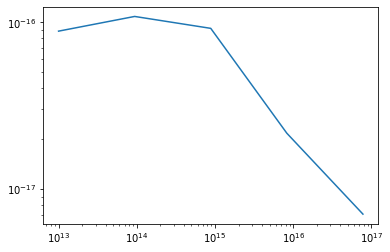

In [11]:
plt.plot(rs, Jeff)
plt.yscale('log')
plt.xscale('log')

In [12]:
I = np.array(model.radiation.I)
u = np.array(model.radiation.u)
v = np.array(model.radiation.v)
J = np.array(model.radiation.J)

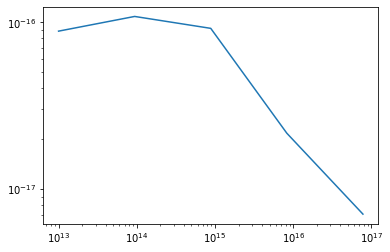

In [13]:
plt.plot(rs, J)
plt.yscale('log')
plt.xscale('log')

In [14]:
rs

array([1.00000000e+13, 9.39774487e+13, 8.83176087e+14, 8.29986354e+15,
       7.80000000e+16])

In [15]:
u[1]

array([[4.59214079e-17],
       [1.02390616e-16],
       [9.38149085e-17],
       [1.95998329e-17],
       [3.94768459e-18]], dtype=float128)

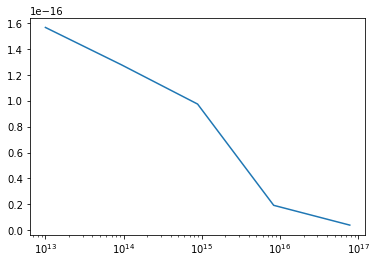

In [16]:
plt.plot(rs, u[2])
# plt.yscale('log')
plt.xscale('log')

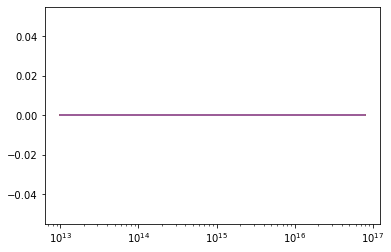

In [17]:
plt.plot(rs, 0.5*(I[0]+I[3]))
# plt.yscale('log')
plt.xscale('log')

In [18]:
np.array(model.geometry.rays.direction)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ],
       [ 0.        ,  1.        ,  0.        ],
       [-1.        , -0.        , -0.        ],
       [-0.70710678, -0.70710678, -0.        ],
       [-0.        , -1.        , -0.        ]])

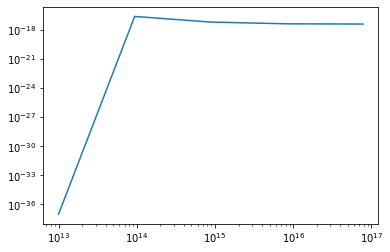

In [13]:
plt.plot(rs, I[0])
plt.yscale('log')
plt.xscale('log')

In [9]:
model.lines.lineProducingSpecies[0].population

array([6.78347209e+04, 1.32165279e+05, 9.25853197e+03, 1.80387926e+04,
       1.26366576e+03, 2.46205389e+03, 1.72473472e+02, 3.36037421e+02,
       2.35403218e+01, 4.58646127e+01, 3.21293903e+00, 6.25990610e+00,
       4.38523198e-01, 8.54393444e-01, 5.98525503e-02, 1.16613276e-01,
       8.16907247e-03, 1.59161522e-02, 1.11496911e-03, 2.17234187e-03],
      dtype=float128)

In [10]:
np.array(model.lines.opacity)

array([[4.38340900e-18],
       [5.98276691e-19],
       [8.16567651e-20],
       [1.11450561e-20],
       [1.52115107e-21],
       [2.07616773e-22],
       [2.83369122e-23],
       [3.86760945e-24],
       [5.27876953e-25],
       [7.20481426e-26]], dtype=float128)

In [11]:
np.array(model.lines.emissivity)

array([[6.96888882e-34],
       [9.51160100e-35],
       [1.29820630e-35],
       [1.77187794e-36],
       [2.41837636e-37],
       [3.30076022e-38],
       [4.50509616e-39],
       [6.14885361e-40],
       [8.39236264e-41],
       [1.14544524e-41]], dtype=float128)

In [15]:
I.shape

(6, 10, 5)

In [3]:
pops = np.array(model.lines.lineProducingSpecies[0].population).reshape((model.parameters.npoints(), 2))
abun = np.array(model.chemistry.species.abundance)[:,1]
rs   = np.linalg.norm(np.array(model.geometry.points.position), axis=1)

In [4]:
(i,ra,rb,nh,tk,nm,vr,db,td,lp0,lp1) = np.loadtxt ('numeric/vanZadelhoff_1a.out', skiprows=14, unpack=True)

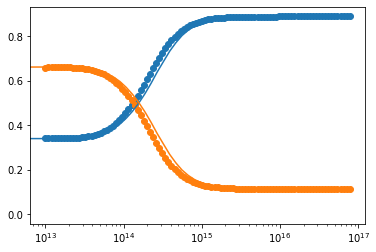

In [5]:
plt.scatter(rs, pops[:,0]/abun)
plt.scatter(rs, pops[:,1]/abun)

plt.plot(ra, lp0)
plt.plot(ra, lp1)


plt.xscale('log')
# plt.yscale('log')

In [7]:
pops = np.array(model.lines.lineProducingSpecies[0].population).reshape((model.parameters.npoints(), 2))
abun = np.array(model.chemistry.species.abundance)[:,1]
r    = np.linalg.norm(np.array(model.geometry.points.position), axis=1)

In [8]:
(i,ra,rb,nh,tk,nm,vr,db,td,lp0,lp1) = np.loadtxt ('numeric/vanZadelhoff_1a.out', skiprows=14, unpack=True)

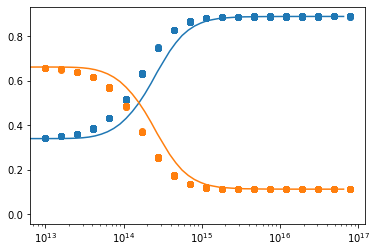

In [12]:
plt.scatter(r, pops[:,0]/abun)
plt.scatter(r, pops[:,1]/abun)

plt.plot(ra, lp0)
plt.plot(ra, lp1)


plt.xscale('log')
# plt.yscale('log')

In [6]:
pops = np.array(model.lines.lineProducingSpecies[0].population).reshape((model.parameters.npoints(), 2))
abun = np.array(model.chemistry.species.abundance)[:,1]
r    = np.linalg.norm(np.array(model.geometry.points.position), axis=1)

In [7]:
(i,ra,rb,nh,tk,nm,vr,db,td,lp0,lp1) = np.loadtxt ('numeric/vanZadelhoff_1a.out', skiprows=14, unpack=True)

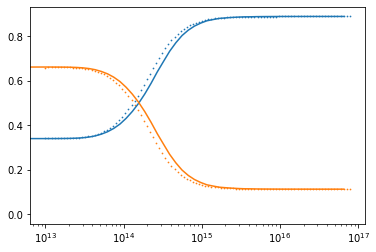

In [9]:
plt.scatter(r, pops[:,0]/abun, s=.5)
plt.scatter(r, pops[:,1]/abun, s=.5)

plt.plot(ra, lp0)
plt.plot(ra, lp1)


plt.xscale('log')
# plt.yscale('log')

In [9]:
np.array(model.geometry.points.position)

array([[1.00000000e+13, 0.00000000e+00, 0.00000000e+00],
       [1.09474781e+13, 0.00000000e+00, 0.00000000e+00],
       [1.19847278e+13, 0.00000000e+00, 0.00000000e+00],
       [1.31202545e+13, 0.00000000e+00, 0.00000000e+00],
       [1.43633700e+13, 0.00000000e+00, 0.00000000e+00],
       [1.57242679e+13, 0.00000000e+00, 0.00000000e+00],
       [1.72141079e+13, 0.00000000e+00, 0.00000000e+00],
       [1.88451070e+13, 0.00000000e+00, 0.00000000e+00],
       [2.06306397e+13, 0.00000000e+00, 0.00000000e+00],
       [2.25853478e+13, 0.00000000e+00, 0.00000000e+00],
       [2.47252601e+13, 0.00000000e+00, 0.00000000e+00],
       [2.70679245e+13, 0.00000000e+00, 0.00000000e+00],
       [2.96325512e+13, 0.00000000e+00, 0.00000000e+00],
       [3.24401706e+13, 0.00000000e+00, 0.00000000e+00],
       [3.55138059e+13, 0.00000000e+00, 0.00000000e+00],
       [3.88786614e+13, 0.00000000e+00, 0.00000000e+00],
       [4.25623296e+13, 0.00000000e+00, 0.00000000e+00],
       [4.65950173e+13, 0.00000

In [10]:
np.array(model.geometry.rays.direction)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.99948622,  0.03205158,  0.        ],
       [ 0.99794539,  0.06407022,  0.        ],
       [ 0.99537911,  0.09602303,  0.        ],
       [ 0.99179001,  0.12787716,  0.        ],
       [ 0.98718178,  0.1595999 ,  0.        ],
       [ 0.98155916,  0.19115863,  0.        ],
       [ 0.97492791,  0.22252093,  0.        ],
       [ 0.96729486,  0.25365458,  0.        ],
       [ 0.95866785,  0.28452759,  0.        ],
       [ 0.94905575,  0.31510822,  0.        ],
       [ 0.93846842,  0.34536505,  0.        ],
       [ 0.92691676,  0.375267  ,  0.        ],
       [ 0.91441262,  0.40478334,  0.        ],
       [ 0.90096887,  0.43388374,  0.        ],
       [ 0.88659931,  0.46253829,  0.        ],
       [ 0.8713187 ,  0.49071755,  0.        ],
       [ 0.85514276,  0.51839257,  0.        ],
       [ 0.8380881 ,  0.5455349 ,  0.        ],
       [ 0.82017225,  0.57211666,  0.        ],
       [ 0.80141362,  0.59811053,  0.   

In [11]:
model.parameters.spherical_symmetry()

True

In [12]:
np.array(model.geometry.rays.antipod)

array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99,  0,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype=uint32)

In [13]:
sum(np.array(model.geometry.rays.weight))

0.99999999999999977123

In [34]:
Jeff = np.array(model.lines.lineProducingSpecies[0].Jeff).ravel()

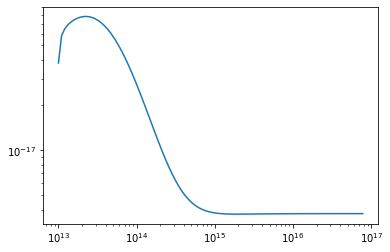

In [35]:
plt.plot(rs, Jeff)
plt.yscale('log')
plt.xscale('log')

In [17]:
I = np.array(model.radiation.I)
J = np.array(model.radiation.J)

In [37]:
I.shape

(100, 100, 15)

In [23]:
wt = np.array(model.geometry.rays.weight)

In [32]:
sum(I[:,-1,-1] * wt)

3.772803340446483841e-18

In [28]:
J[0]

array([3.77282562e-18, 3.77425627e-18, 3.92481634e-18, 8.15400194e-18,
       3.96115101e-17, 5.95616022e-17, 3.72080548e-17, 2.76795468e-17,
       3.72079863e-17, 5.95615489e-17, 3.96116615e-17, 8.15403083e-18,
       3.92480449e-18, 3.77423942e-18, 3.77280492e-18], dtype=float128)